# Criação da base de dados para detecção de anomalias

## Cenário 1 - Benign->DNS->Benign->UDP->Benign

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def collectAttack(filepath, nrows=None):
    df = pd.read_csv(filepath, low_memory=False, nrows=nrows)
    
    # Limpeza básica
    df.columns = df.columns.str.strip()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df = df.dropna(subset=['Timestamp'])
    df = df.sort_values('Timestamp')
    
    return df

def joinFlowAttack(caminho_benigno_mestre, lista_dfs_ataques, output_path):
    df_benign = pd.read_csv(caminho_benigno_mestre)
    df_benign.columns = df_benign.columns.str.strip()
    df_benign['Timestamp'] = pd.to_datetime(df_benign['Timestamp'], errors='coerce')
    df_benign = df_benign.dropna(subset=['Timestamp'])
    
    total_benigno_original = len(df_benign)
    
    # Remover intervalos conflitantes
    mask_keep = pd.Series([True] * len(df_benign), index=df_benign.index)
    
    for i, df_atk in enumerate(lista_dfs_ataques):
        start_time = df_atk['Timestamp'].min()
        end_time = df_atk['Timestamp'].max()
        
        # Identifica colisões
        colisao = (df_benign['Timestamp'] >= start_time) & (df_benign['Timestamp'] <= end_time)
        n_removidos = colisao.sum()
        
        # Atualiza a máscara 
        mask_keep = mask_keep & (~colisao)
        
        print(f"   -> Ataque #{i+1} ({start_time} até {end_time}): Removeu {n_removidos} linhas benignas.")

    # Aplica o corte
    df_benign_final = df_benign[mask_keep]
    
    # Fusão e Ordenação
    todos_dfs = [df_benign_final] + lista_dfs_ataques
    df_final = pd.concat(todos_dfs)
    
    # Ordenação final crucial
    df_final = df_final.sort_values('Timestamp')
    
    # Salvar
    df_final.to_csv(output_path, index=False)
    print(f"\n[SUCESSO] Arquivo salvo em: {output_path}")
    print(f"Total Original Benigno: {total_benigno_original}")
    print(f"Total Final Ataques: {sum(len(df) for df in lista_dfs_ataques)}")
    print(f"Total Final Dataset: {len(df_final)}")
    
    return output_path


def plotDensity(csv_path, window_size=50):
    df = pd.read_csv(csv_path)
    
    is_attack = np.where(df['Label'].str.upper() != 'BENIGN', 1, 0)
    is_benign = np.where(df['Label'].str.upper() == 'BENIGN', 1, 0)
    
    # Média Móvel
    s_attack = pd.Series(is_attack).rolling(window=window_size).mean()
    s_benign = pd.Series(is_benign).rolling(window=window_size).mean()
    
    # Plot
    plt.figure(figsize=(15, 5))
    plt.fill_between(range(len(df)), s_benign, color='#2ca02c', alpha=0.3, label='Normal')
    plt.fill_between(range(len(df)), s_attack, color='#d62728', alpha=0.3, label='Ataque')
    
    # Linhas
    plt.plot(s_benign, color='#2ca02c', alpha=0.9, linewidth=1.5)
    plt.plot(s_attack, color='#d62728', alpha=0.9, linewidth=1.5)
    
    # Decoração simples
    plt.title(f"Fluxo Resultante (Janela Média Móvel: {window_size})", fontsize=12)
    plt.xlabel("Sequência de Amostras")
    plt.ylabel("Densidade")
    plt.yticks([0, 1], ['0%', '100%'])
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


   -> Ataque #1 (2018-12-01 10:51:39.813448 até 2018-12-01 10:51:43.277739): Removeu 8 linhas benignas.
   -> Ataque #2 (2018-12-01 12:36:57.628026 até 2018-12-01 12:36:57.653114): Removeu 0 linhas benignas.

[SUCESSO] Arquivo salvo em: Teste_DNS_UDP.csv
Total Original Benigno: 56863
Total Final Ataques: 400
Total Final Dataset: 57255


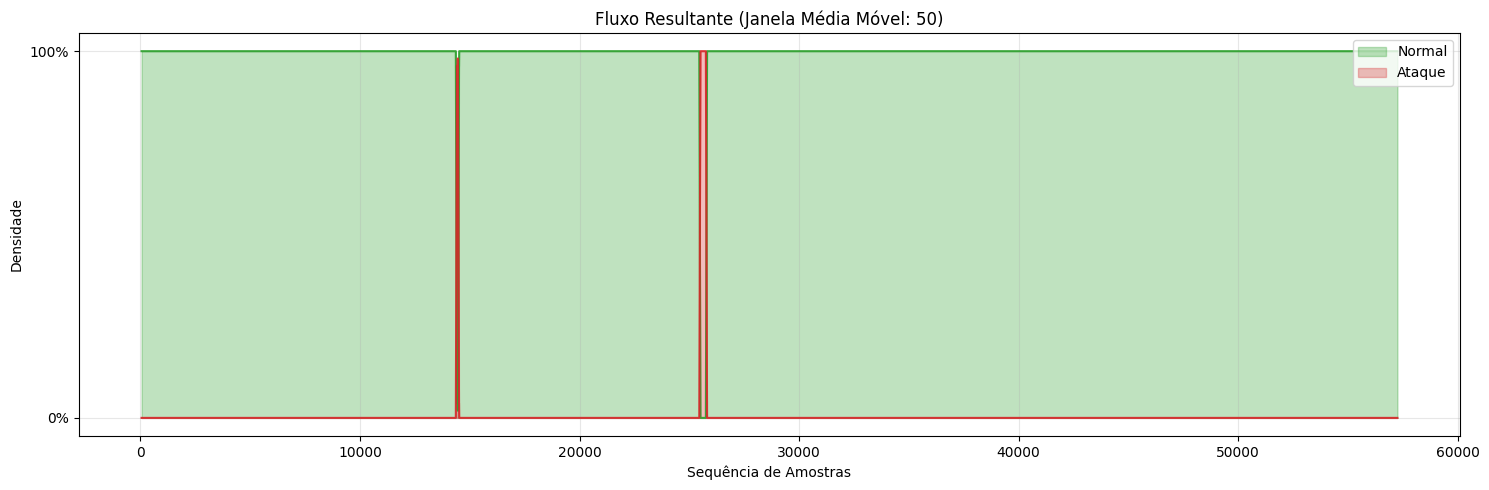

In [2]:
BASE_DIR = "datasets/CICDDoS2019"
PATH_BENIGNO = os.path.join(BASE_DIR, "data", "benign_0112.csv")
PATH_DNS = os.path.join(BASE_DIR, "01-12", "DrDoS_DNS.csv")
PATH_UDP = os.path.join(BASE_DIR, "01-12", "DrDoS_UDP.csv")
ARQUIVO_FINAL = "Teste_DNS_UDP.csv"

# Preparar os ataques
df_dns = collectAttack(PATH_DNS, nrows=100)
df_udp = collectAttack(PATH_UDP, nrows=300)

# Realizar a fusão cirúrgica
joinFlowAttack(
    caminho_benigno_mestre=PATH_BENIGNO,
    lista_dfs_ataques=[df_dns, df_udp],
    output_path=ARQUIVO_FINAL
)

# Visualizar o resultado
if os.path.exists(ARQUIVO_FINAL):
    plotDensity(ARQUIVO_FINAL, window_size=50)

# Janelamento das Amostras

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import os

def calcular_entropia(series):
    if series.empty:
        return 0
    counts = series.value_counts()
    return entropy(counts, base=2)

def processar_dataset_temporal(input_path, output_path, freq='1s', chunk_size=200000):
    reader = pd.read_csv(
        input_path, 
        chunksize=chunk_size, 
        low_memory=True, 
        engine='python', 
        on_bad_lines='warn', 
        sep=None             
    )
    
    primeiro_chunk = True

    for i, chunk in enumerate(reader):
        # Limpeza básica de nomes de colunas
        chunk.columns = chunk.columns.str.strip()
        
        # Converte Timestamp tratando erros
        chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], errors='coerce')
        chunk = chunk.dropna(subset=['Timestamp']).set_index('Timestamp')
        
        dict_agg = {}
        cols_entropia = []

        for col in chunk.columns:
            # Entropia para Identificadores
            if any(x in col for x in ['IP', 'Port', 'Protocol']):
                dict_agg[col] = calcular_entropia
                cols_entropia.append(col)
            
            # Label (Moda ou BENIGN)
            elif col == 'Label':
                dict_agg[col] = lambda x: x.mode()[0] if not x.empty else 'BENIGN'
            
            # Somatório para colunas numéricas
            elif pd.api.types.is_numeric_dtype(chunk[col]):
                dict_agg[col] = 'sum'

        # Executa o Janelamento 
        resumo = chunk.resample(freq).agg(dict_agg)
        
        # Preenche gaps temporais
        if 'Label' in resumo.columns:
            resumo['Label'] = resumo['Label'].fillna('BENIGN')
            resumo['Label'] = resumo['Label'].replace('N/A', 'BENIGN')
        
        resumo = resumo.fillna(0)

        # Renomeia colunas de Entropia
        rename_map = {col: f"{col}_Entropy" if col in cols_entropia else col for col in resumo.columns}
        resumo = resumo.rename(columns=rename_map)

        # Garante que Label seja a última coluna
        final_cols = [c for c in resumo.columns if c != 'Label']
        if 'Label' in resumo.columns:
            final_cols.append('Label')
        
        resumo = resumo[final_cols]

        # Salva o progresso
        header_bool = True if primeiro_chunk else False
        mode_str = 'w' if primeiro_chunk else 'a'
        
        resumo.to_csv(output_path, mode=mode_str, header=header_bool)
        primeiro_chunk = False

    print(f"Processamento concluído. Arquivo salvo: {output_path}")

In [5]:
ARQUIVO_ENTRADA = 'datasets/CICDDoS2019/01-12/DrDoS_SNMP.csv' 
ARQUIVO_SAIDA = 'DrDoS_SNMP_1s_0112.csv'
FREQUENCIA = '1s'  # Ex: '1S' (1 seg), '500L' (500ms), '200L' (200ms)              
    
processar_dataset_temporal(
    input_path=ARQUIVO_ENTRADA, 
    output_path=ARQUIVO_SAIDA, 
    freq=FREQUENCIA,
    chunk_size=150000
)

Processamento concluído. Arquivo salvo: DrDoS_SNMP_1s_0112.csv


In [4]:
ARQUIVO_ENTRADA = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv' 
ARQUIVO_SAIDA = 'DrDoS_DNS_1s_0112.csv'
FREQUENCIA = '1s'  # Ex: '1S' (1 seg), '500L' (500ms), '200L' (200ms)            
    
processar_dataset_temporal(
    input_path=ARQUIVO_ENTRADA, 
    output_path=ARQUIVO_SAIDA, 
    freq=FREQUENCIA,

    chunk_size=150000
)

Processamento concluído. Arquivo salvo: DrDoS_DNS_1s_0112.csv


In [6]:
ARQUIVO_ENTRADA = 'datasets/CICDDoS2019/data/benign_0112.csv' 
ARQUIVO_SAIDA = 'BENIGN_1s_0112.csv'
FREQUENCIA = '1s'  # Ex: '1S' (1 seg), '500L' (500ms), '200L' (200ms)           
    
processar_dataset_temporal(
    input_path=ARQUIVO_ENTRADA, 
    output_path=ARQUIVO_SAIDA, 
    freq=FREQUENCIA,
    chunk_size=150000
)

Processamento concluído. Arquivo salvo: BENIGN_1s_0112.csv


# Mesclagem dos ataques

In [8]:
import pandas as pd
import os
import time

def mesclar_ataques_no_benigno(
    path_benign, 
    list_paths_attacks, 
    output_path, 
    chunk_size=200000
):
    df_attacks = pd.DataFrame()
    
    for atk_path in list_paths_attacks:
        if os.path.exists(atk_path):
            try:
                df_temp = pd.read_csv(atk_path, low_memory=False, on_bad_lines='skip')
                df_temp.columns = df_temp.columns.str.strip()
                
                # Garante datetime
                df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'], errors='coerce')
                df_temp = df_temp.dropna(subset=['Timestamp'])
                
                df_attacks = pd.concat([df_attacks, df_temp])
            except Exception as e:
                print(f"   ERRO ao ler {atk_path}: {e}")
        else:
            print(f"   AVISO: Arquivo não encontrado: {atk_path}")

    if df_attacks.empty:
        print("ERRO CRÍTICO: Nenhum dado de ataque válido carregado. Abortando.")
        return

    # Remove duplicatas de timestamps nos ataques
    df_attacks = df_attacks.drop_duplicates(subset=['Timestamp'], keep='last')
    
    # Define Timestamp como índice para substituição rápida
    df_attacks.set_index('Timestamp', inplace=True)
    
    if os.path.exists(output_path):
        os.remove(output_path)
    
    first_chunk = True
    total_processed = 0
    total_replaced = 0

    # Adicionamos on_bad_lines aqui também por segurança
    with pd.read_csv(path_benign, chunksize=chunk_size, low_memory=False, on_bad_lines='skip') as reader:
        for i, chunk in enumerate(reader):
            chunk.columns = chunk.columns.str.strip()
            
            chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], errors='coerce')
            
            # Guardamos a coluna Timestamp original para resetar depois
            chunk.set_index('Timestamp', inplace=True)
            
            # Verifica interseção de índices 
            common_indices = chunk.index.intersection(df_attacks.index)
            
            if not common_indices.empty:
                chunk.loc[common_indices] = df_attacks.loc[common_indices]
                total_replaced += len(common_indices)
            
            chunk.reset_index(inplace=True)
            
            # Tratamento de N/A e preenchimento
            chunk['Label'] = chunk['Label'].fillna('BENIGN')
            chunk = chunk.fillna(0)

            mode = 'w' if first_chunk else 'a'
            header = first_chunk
            chunk.to_csv(output_path, mode=mode, header=header, index=False)
            
            total_processed += len(chunk)
            first_chunk = False
            

In [10]:
ARQUIVO_BENIGNO = "BENIGN_1s_0112.csv"
ARQUIVO_FINAL = "SNMP_DNS_1s_0112.csv"
LISTA_ATAQUES = [
    "DrDoS_SNMP_1s_0112.csv",
    "DrDoS_DNS_1s_0112.csv"
]

mesclar_ataques_no_benigno(ARQUIVO_BENIGNO, LISTA_ATAQUES, ARQUIVO_FINAL)

# Rotulagem e Filtro MURILO

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

def filter_and_label_by_time(
    raw_input_path, 
    final_output_path, 
    global_start_str, 
    global_end_str, 
    attacks_ground_truth=None,
    timestamp_col='timestamp', 
    date_format='%Y-%m-%d %H:%M:%S', 
    chunk_size=50000
):
    
    print(f"Período Global: {global_start_str} até {global_end_str}")
    print(f"Formato de Data esperado: {date_format}")
    
    # Converte limites globais usando o formato explícito
    try:
        global_start = pd.to_datetime(global_start_str, format=date_format)
        global_end = pd.to_datetime(global_end_str, format=date_format)
    except ValueError as e:
        print(f"ERRO: As datas de início/fim passadas não batem com o formato {date_format}.")
        print(f"Detalhe: {e}")
        return

    # Prepara lista de ataques
    attack_rules = []
    if attacks_ground_truth:
        for start, end, label in attacks_ground_truth:
            start_dt = pd.to_datetime(start, format=date_format)
            end_dt = pd.to_datetime(end, format=date_format)
            attack_rules.append((start_dt, end_dt, label))
    
    if os.path.exists(final_output_path):
        os.remove(final_output_path)
        print(f"Arquivo antigo removido: {final_output_path}")
        
    first_chunk = True
    total_rows_saved = 0
    with pd.read_csv(raw_input_path, chunksize=chunk_size, low_memory=False) as reader:
        
        for i, chunk in enumerate(reader):
            chunk.columns = chunk.columns.str.strip()
            
            if timestamp_col not in chunk.columns:
                print(f"ERRO: Coluna '{timestamp_col}' não encontrada neste chunk.")
                print(f"Colunas disponíveis: {chunk.columns.tolist()}")
                break 
            try:
                chunk[timestamp_col] = pd.to_datetime(chunk[timestamp_col], format=date_format, errors='coerce')
            except Exception as e:
                print(f"Aviso no Chunk {i}: Formato falhou, tentando inferência lenta...")
                chunk[timestamp_col] = pd.to_datetime(chunk[timestamp_col], errors='coerce')

            # Remove linhas onde a data virou NaT (Not a Time) por erro de formatação
            original_len = len(chunk)
            chunk = chunk.dropna(subset=[timestamp_col])
            if len(chunk) < original_len:
                print(f"   -> Aviso: {original_len - len(chunk)} linhas removidas por data inválida no chunk {i+1}")
            
            # FILTRAGEM
            mask_global = (chunk[timestamp_col] >= global_start) & (chunk[timestamp_col] <= global_end)
            df_filtered = chunk.loc[mask_global].copy()
            
            if df_filtered.empty:
                continue

            # ROTULAGEM
            df_filtered['Label'] = 'BENIGN'
            
            for atk_start, atk_end, atk_name in attack_rules:
                mask_attack = (df_filtered[timestamp_col] >= atk_start) & \
                              (df_filtered[timestamp_col] <= atk_end)
                df_filtered.loc[mask_attack, 'Label'] = atk_name
            
            # SALVAMENTO
            mode = 'w' if first_chunk else 'a'
            header = first_chunk
            
            df_filtered.to_csv(final_output_path, mode=mode, header=header, index=False)
            
            total_rows_saved += len(df_filtered)
            first_chunk = False

    print(f"\nConcluído! Arquivo salvo em: {final_output_path}")
    print(f"Total de linhas no dataset final: {total_rows_saved}")

In [8]:
MEU_FORMATO = '%Y-%m-%d %H:%M:%S' 
PERIODO_INICIO = "2025-10-13 12:00:00"
PERIODO_FIM    = "2025-10-13 18:20:00"
ATAQUES = [
    ("2025-10-13 15:26:30", "2025-10-13 17:16:20", "Syn")
]
ARQUIVO_BRUTO = "datasets/MURILO/synack/test_features_1s.txt" 
ARQUIVO_FINAL = "syn.csv"


# Chame a função passando o date_format
filter_and_label_by_time(
    raw_input_path=ARQUIVO_BRUTO,
    final_output_path=ARQUIVO_FINAL,
    global_start_str=PERIODO_INICIO,
    global_end_str=PERIODO_FIM,
    attacks_ground_truth=ATAQUES,
    date_format=MEU_FORMATO,   
    chunk_size=100000
)


>>> Iniciando processamento...
Período Global: 2025-10-13 12:00:00 até 2025-10-13 18:20:00
Formato de Data esperado: %Y-%m-%d %H:%M:%S

>>> Concluído! Arquivo salvo em: syn.csv
Total de linhas no dataset final: 22776


In [5]:
MEU_FORMATO = '%Y-%m-%d %H:%M:%S' 
PERIODO_INICIO = "2025-07-16 17:00:00"
PERIODO_FIM    = "2025-07-17 03:00:00"
ATAQUES = [
    ("2025-07-16 20:27:14", "2025-07-16 20:32:14", "http-flood"),
    ("2025-07-16 22:23:07", "2025-07-16 22:23:07", "http-flood"),
    ("2025-07-16 22:24:57", "2025-07-16 22:25:03", "http-flood"),
    ("2025-07-16 22:33:05", "2025-07-16 22:33:07", "http-flood"),
    ("2025-07-17 00:09:16", "2025-07-17 00:09:19", "http-flood"),
    ("2025-07-17 00:30:15", "2025-07-17 00:30:17", "http-flood")
]
ARQUIVO_BRUTO = "datasets/MURILO/http-flood/test_features_1s.txt" 
ARQUIVO_FINAL = "datasets/MURILO/http-flood.csv"


# Chame a função passando o date_format
filter_and_label_by_time(
    raw_input_path=ARQUIVO_BRUTO,
    final_output_path=ARQUIVO_FINAL,
    global_start_str=PERIODO_INICIO,
    global_end_str=PERIODO_FIM,
    attacks_ground_truth=ATAQUES,
    date_format=MEU_FORMATO,   
    chunk_size=100000
)

Período Global: 2025-07-16 17:00:00 até 2025-07-17 03:00:00
Formato de Data esperado: %Y-%m-%d %H:%M:%S
Arquivo antigo removido: datasets/MURILO/http-flood.csv

Concluído! Arquivo salvo em: datasets/MURILO/http-flood.csv
Total de linhas no dataset final: 35715


In [4]:
MEU_FORMATO = '%Y-%m-%d %H:%M:%S' 
PERIODO_INICIO = "2025-10-15 17:00:00"
PERIODO_FIM    = "2025-10-16 02:04:59"
ATAQUES = [
    ("2025-10-15 20:28:40", "2025-10-15 20:42:10", "udp"),
    ("2025-10-15 20:53:40", "2025-10-15 21:06:20", "udp"),
    ("2025-10-15 22:44:20", "2025-10-15 22:54:40", "udp"),
    ("2025-10-16 00:10:40", "2025-10-16 00:19:40", "udp")
]
ARQUIVO_BRUTO = "datasets/MURILO/udp/test_features_1s.txt" 
ARQUIVO_FINAL = "datasets/MURILO/udp.csv"


# Chame a função passando o date_format
filter_and_label_by_time(
    raw_input_path=ARQUIVO_BRUTO,
    final_output_path=ARQUIVO_FINAL,
    global_start_str=PERIODO_INICIO,
    global_end_str=PERIODO_FIM,
    attacks_ground_truth=ATAQUES,
    date_format=MEU_FORMATO,   
    chunk_size=100000
)

Período Global: 2025-10-15 17:00:00 até 2025-10-16 02:04:59
Formato de Data esperado: %Y-%m-%d %H:%M:%S

Concluído! Arquivo salvo em: datasets/MURILO/udp.csv
Total de linhas no dataset final: 32700
